# Clustering Anomaly Detection

In [36]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datautils import get_morning_data, get_gcnae_sequence, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_gcnae, compute_anomaly_threshold_gcnae, test_model, threshold_anomalies, fill_result_df, test_gcnae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc
import torch.nn as nn
from tqdm import tqdm

import random
import os

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# ADDITIONAL PACKAGE NEEDED FOR THIS FILE:
from kneed import KneeLocator


In [37]:
train_data, test_data, _ = get_full_data()
train_data = normalize_data(train_data)
train_data = label_anomalies(train_data)

# Remove anomalies from the data used to form the initial clusters
train_data = train_data[train_data['anomaly'] == 0]

In [38]:
train_features = train_data[['speed', 'occ', 'volume']].to_numpy()

/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_in

The optimal number of clusters (k) is: 3


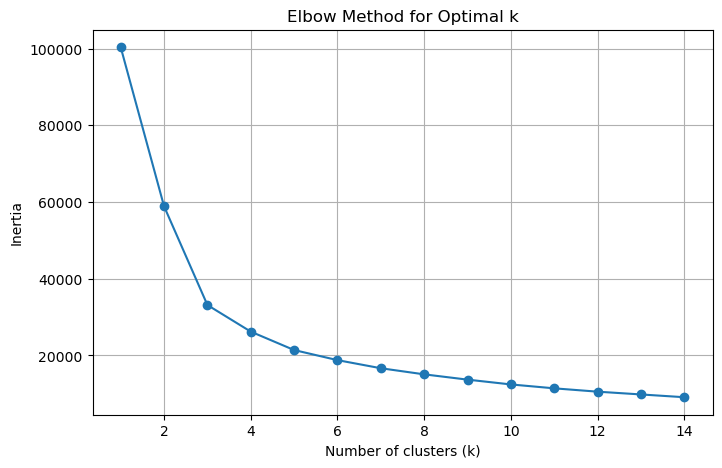

In [39]:
# Hyperparameter optimization
inertia = []
k_values = range(1, 15)  # Test k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_features)
    inertia.append(kmeans.inertia_)

kneedle = KneeLocator(k_values, inertia, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

print(f"The optimal number of clusters (k) is: {optimal_k}")

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [40]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(train_features)

# Get the cluster assignments and centroids
clusters = kmeans.labels_
centroids = kmeans.cluster_centers_

/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/tmp/ipykernel_3220386/1437224627.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_clusters))


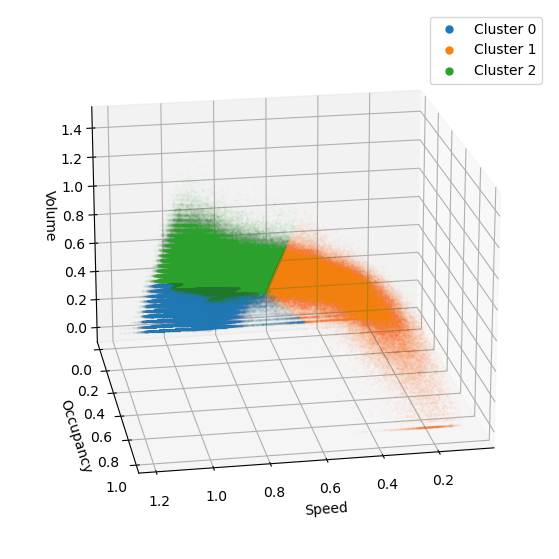

In [41]:
import matplotlib.lines as mlines

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Assuming clusters is an array where each value represents a cluster index
unique_clusters = set(clusters)
colors = plt.cm.get_cmap('tab10', len(unique_clusters))

legend_handles = []

for cluster_id in unique_clusters:
    cluster_points = train_features[clusters == cluster_id]
    scatter = ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
               label=f'Cluster {cluster_id}', s=1, alpha=0.01)

    # Create a custom handle for the legend with no alpha
    legend_handle = mlines.Line2D([], [], color=scatter.get_edgecolor()[0], marker='o', linestyle='None', markersize=5, alpha=1.0)
    legend_handles.append((legend_handle, f'Cluster {cluster_id}'))

ax.set_xlabel('Speed')
ax.set_ylabel('Occupancy')
ax.set_zlabel('Volume')
# Create the legend using the custom handles
ax.legend(handles=[handle for handle, _ in legend_handles],
          labels=[label for _, label in legend_handles])
ax.view_init(20,80)
plt.show()

In [42]:
# Calculate the minimum distance of each point to its cluster centroid
cluster_labels, train_distances = pairwise_distances_argmin_min(train_features, centroids)

In [43]:
centroids

array([[0.90695431, 0.04308542, 0.1842505 ],
       [0.40800813, 0.27666482, 0.39148794],
       [0.85644588, 0.11938705, 0.5004574 ]])

In [44]:
train_features

array([[0.98702011, 0.02      , 0.04      ],
       [0.87205837, 0.03      , 0.04      ],
       [0.87133722, 0.03      , 0.08      ],
       ...,
       [0.92413921, 0.13      , 0.56      ],
       [0.83614541, 0.09      , 0.24      ],
       [0.8252014 , 0.01      , 0.08      ]])

In [45]:
train_distances

array([0.16658835, 0.14898712, 0.1109413 , ..., 0.09077633, 0.1016016 ,
       0.13655164])

In [46]:
# Setting a threshold for anomalies (e.g., top 5% of distances)
threshold = np.percentile(train_distances, 95)

threshold

0.28012602184163304

In [47]:
test_data = normalize_data(test_data)
test_anomalies = label_anomalies(test_data)

In [48]:
test_features = test_data[['speed', 'occ', 'volume']].to_numpy()
test_clusters, test_distances = pairwise_distances_argmin_min(test_features, centroids)
anomalies = np.where(test_distances > threshold)[0]
print(len(anomalies))

69910


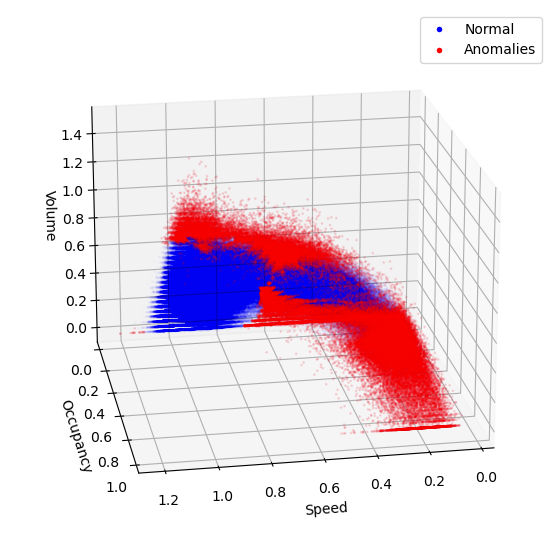

In [49]:
from matplotlib.lines import Line2D

# Plotting the nodes and highlighting the anomalies
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot normal nodes
ax.scatter(test_features[:, 0], test_features[:, 1], test_features[:, 2], c='blue', label='Normal', s=1, alpha=0.01)

# Plot anomalies
ax.scatter(test_features[anomalies, 0], test_features[anomalies, 1], test_features[anomalies, 2], 
           c='red', label='Anomalies', s=1, alpha=0.1)

ax.set_xlabel('Speed')
ax.set_ylabel('Occupancy')
ax.set_zlabel('Volume')
# Custom legend handles
normal_handle = Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='Normal')
anomaly_handle = Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='Anomalies')

ax.legend(handles=[normal_handle, anomaly_handle])
ax.view_init(20,80)
plt.show()


In [50]:
# Whether a crash was reported at each time
crash_reported = test_data['crash_record'].to_numpy()[0::196]

### Compute FPR / Crash Detection Delay Tradeoff

In [51]:
test_distances

array([0.09888982, 0.14954623, 0.1985391 , ..., 0.08146003, 0.10826838,
       0.11786467])

In [58]:
thresh = np.ones(196) * threshold

In [63]:
test_distances.reshape(-1,196).shape

(4800, 196)

In [59]:
crash_reported.shape

(4800,)

In [65]:
delay_results = np.array(find_delays(thresh, test_distances.reshape(-1,196), test_data['anomaly'], crash_reported, True))

100%|██████████| 1000/1000 [12:15<00:00,  1.36it/s]
/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scal

In [66]:
delay_df = pd.DataFrame(delay_results, columns=['FPR', 'Mean Delay', 'Std Delay', 'Found Percent'])
delay_df.to_csv('./saved_results/cluster_fp_delay.csv')

In [71]:
delay_df

,FPR,Mean Delay,Std Delay,Found Percent
0,0.000000,NaN,NaN,0.000000
1,0.008605,24.000000,0.000000,0.083333
2,0.021739,14.333333,15.839472,0.250000
3,0.030344,7.200000,18.787230,0.416667
4,0.041214,-1.833333,19.556897,0.500000
...,...,...,...,...
95,0.956975,-30.000000,0.000000,1.000000
96,0.966486,-30.000000,0.000000,1.000000
97,0.979620,-30.000000,0.000000,1.000000
98,0.987772,-30.000000,0.000000,1.000000


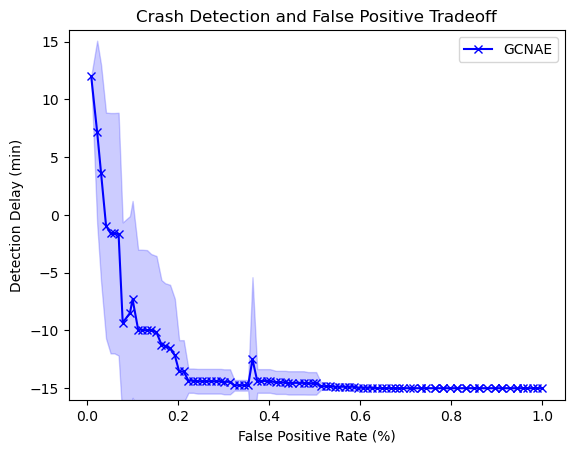

In [67]:
x_values = delay_df['FPR']
y_values = delay_df['Mean Delay'] / 2
std_values = delay_df['Std Delay'] / 2

plt.plot(x_values, y_values, color='blue', label='GCNAE', marker='x')

lower_bound = y_values - std_values  # 1.96 is the z-score for 95% confidence interval
upper_bound = y_values + std_values

plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylim(-16, 16)
# plt.xlim(-0.01,1)
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Detection Delay (min)")
plt.title("Crash Detection and False Positive Tradeoff")
plt.legend()
plt.show()

In [118]:
closest_index = np.abs(x_values - 0.01).argmin()
print("Detection Delay Mean:", y_values[closest_index])
print("Detection Delay std:", std_values[closest_index])
print("Miss percentage:", 1-delay_df['Found Percent'].to_numpy()[closest_index])

Detection Delay Mean: 12.0
Detection Delay std: 0.0
Miss percentage: 0.9166666666666666


In [119]:
closest_index = np.abs(x_values - 0.05).argmin()
print("Detection Delay Mean:", y_values[closest_index])
print("Detection Delay std:", std_values[closest_index])
print("Miss percentage:", 1-delay_df['Found Percent'].to_numpy()[closest_index])

Detection Delay Mean: -1.5833333333333333
Detection Delay std: 10.405994533067092
Miss percentage: 0.5


In [120]:
closest_index = np.abs(x_values - 0.1).argmin()
print("Detection Delay Mean:", y_values[closest_index])
print("Detection Delay std:", std_values[closest_index])
print("Miss percentage:", 1-delay_df['Found Percent'].to_numpy()[closest_index])

Detection Delay Mean: -7.3125
Detection Delay std: 8.525467362555556
Miss percentage: 0.33333333333333337


In [121]:
closest_index = np.abs(x_values - 0.2).argmin()
print("Detection Delay Mean:", y_values[closest_index])
print("Detection Delay std:", std_values[closest_index])
print("Miss percentage:", 1-delay_df['Found Percent'].to_numpy()[closest_index])

Detection Delay Mean: -13.555555555555555
Detection Delay std: 2.7125679146074893
Miss percentage: 0.25


### Compute AUC

In [74]:
calculate_auc(test_distances.reshape(-1,196), test_data['anomaly'].to_numpy())

0.5960670862967435